In [1]:
import codecs
import csv
import geopandas as gpd
import itertools
import jaconv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import xlrd

from functools import reduce
from shapely.geometry import Point, LineString

plt.rcParams['figure.figsize'] = (20, 20)
%matplotlib inline

In [2]:
# TODO add hourly log
# TODO remove unused stations

In [3]:
!ls ../data/railroad

001178999.xlsx			      odpt_PassengerSurvey_rinkai.json
001179235.xlsx			      odpt_PassengerSurvey_tama.json
001179689.xlsx			      odpt_PassengerSurvey_toei.json
N02-18_RailroadSection.geojson	      odpt_PassengerSurvey_tx.json
N02-18_Station.geojson		      odpt_PassengerSurvey_yokohama.json
S12-18_NumberOfPassengers.geojson     tn16qa040800.xls
odpt_PassengerSurvey_JREast.json      tn16qa041300.xls
odpt_PassengerSurvey_TokyoMetro.json  tn16qa041500.xls


In [4]:
def read_station_code(src_dir='../data/railroad'):
    wb = xlrd.open_workbook(os.path.join(src_dir, '001179689.xlsx'))

    sheet = wb.sheets()[0]

    operator_jp, operator_en, route_jp, route_en = [None] * 4
    route_count = 0
    records = []

    col_num = len(sheet.row_values(0))
    row_num = len(sheet.col_values(0))

    for x in range(1, row_num):
        record = sheet.row_values(x)
        records.append(record)
    df = pd.DataFrame(records, columns=['station_code', 'operator_jp', 'route_jp', 'station_jp', 'operator_code', 'route_code'])
    # 京葉線（１） -> 京葉線,  上野東京ライン（1） -> 上野東京ライン
    df['route_jp'] = df['route_jp'].apply(lambda x: re.sub(r'[(（][0-9０-９][)）]', '', x))
    replace_list = [
        ('高尾線', '京王線'),
        ('動物園線', '京王線'),
        ('相模原線', '京王線'),
        ('伊勢崎線', '東武スカイツリーライン'),
        ('各駅停車', ''),
        ('快速', ''),
        (' ', ''),
    ]
    df['route_jp'] = df['route_jp'].apply(lambda x: reduce(lambda a,b: a.replace(*b), replace_list, x))
    df['route_jp'] = df['route_jp'].apply(lambda x: jaconv.h2z(x))
    df['station_jp'] = df['station_jp'].apply(lambda x: jaconv.h2z(x, digit=True))

    df['route_station_jp'] = df.apply(lambda x: '{}_{}'.format(x['route_jp'], x['station_jp']), axis=1)
    return df
df_station_code = read_station_code()
df_station_code

,station_code,operator_jp,route_jp,station_jp,operator_code,route_code,route_station_jp
0,00101,東日本旅客鉄道,東海道本線,東京,01,001,東海道本線_東京
1,00102,東日本旅客鉄道,東海道本線,新橋,01,001,東海道本線_新橋
2,00103,東日本旅客鉄道,東海道本線,品川,01,001,東海道本線_品川
3,00104,東日本旅客鉄道,東海道本線,川崎,01,001,東海道本線_川崎
4,00105,東日本旅客鉄道,東海道本線,横浜,01,001,東海道本線_横浜
...,...,...,...,...,...,...,...
2047,98009,埼玉新都市交通,伊奈線,丸山,98,980,伊奈線_丸山
2048,98010,埼玉新都市交通,伊奈線,志久,98,980,伊奈線_志久
2049,98011,埼玉新都市交通,伊奈線,伊奈中央,98,980,伊奈線_伊奈中央
2050,98012,埼玉新都市交通,伊奈線,羽貫,98,980,伊奈線_羽貫


In [5]:
def read_odpt_passenger_survey(src_dir='../data/railroad/'):
    survey_files = [
        'odpt_PassengerSurvey_JREast.json',
        'odpt_PassengerSurvey_rinkai.json',
        'odpt_PassengerSurvey_tama.json',
        'odpt_PassengerSurvey_toei.json',
        'odpt_PassengerSurvey_TokyoMetro.json',
        'odpt_PassengerSurvey_tx.json',
        'odpt_PassengerSurvey_yokohama.json',
    ]
    survey_data = [json.load(open(os.path.join(src_dir, x), 'r')) for x in survey_files]
    survey_data = reduce(lambda x,y:x+y, survey_data)
    df = []
    for station in survey_data:
        record = {
            'name_en': station['odpt:station'][0].replace('odpt.Station:', '').split('.')[2],
            'route_en': station['odpt:station'][0].replace('odpt.Station:', '').split('.')[1],
            'operator_en': station['odpt:operator'].replace('odpt.Operator:', ''),
            **{
                'odpt_passenger_journeys_{}'.format(x['odpt:surveyYear']): x['odpt:passengerJourneys'] for x in station['odpt:passengerSurveyObject']
            }
        }
        df.append(record)

    return pd.DataFrame(df)

df_odpt_passenger_survey = read_odpt_passenger_survey()
df_odpt_passenger_survey

,name_en,route_en,operator_en,odpt_passenger_journeys_2013,odpt_passenger_journeys_2014,odpt_passenger_journeys_2015,odpt_passenger_journeys_2016,odpt_passenger_journeys_2017,odpt_passenger_journeys_2018
0,Akatsuka,Joban,JR-East,5894.0,5916.0,6154.0,6249.0,6313.0,6277.0
1,Abiko,JobanLocal,JR-East,30289.0,29872.0,30345.0,30866.0,31172.0,31584.0
2,Ageo,Takasaki,JR-East,41850.0,41168.0,41770.0,41747.0,42010.0,42210.0
3,Hinatawada,Ome,JR-East,1015.0,893.0,NaN,NaN,NaN,NaN
4,Aihara,Yokohama,JR-East,10421.0,10143.0,10320.0,10610.0,10647.0,10617.0
...,...,...,...,...,...,...,...,...,...
899,Tateba,Blue,YokohamaMunicipal,22247.0,21630.0,22368.0,22659.0,22521.0,NaN
900,Totsuka,Blue,YokohamaMunicipal,86947.0,87837.0,88940.0,89218.0,89349.0,NaN
901,TsuzukiFureainooka,Green,YokohamaMunicipal,18758.0,19210.0,20222.0,20793.0,21075.0,NaN
902,Yokohama,Blue,YokohamaMunicipal,134131.0,132277.0,135150.0,135746.0,141375.0,NaN


In [6]:
nlni_replace_list = [
    ('1', ''),
    ('分岐線', ''),
    ('東京モノレール羽田線', '東京モノレール'),
    ('東海道線', '東海道本線'),
    ('伊勢崎線', '東武スカイツリーライン'),
    ('動物園線', '京王線'),
    ('相模原線', '京王線'),
    ('競馬場線', '京王線'),
    ('高尾線', '京王線'),
    ('中央線', '中央本線'),
    ('赤羽線（埼京線）', '埼京線'),
    ('東北線（埼京線）', '埼京線'),
    ('東北線', '東北本線'),
    ('東上本線', '東上線'),
    ('ケーブルカー', '高尾鋼索線'),
]
def read_nlni_station(src_dir='../data/railroad'):
    df = gpd.read_file(os.path.join(src_dir, 'N02-18_Station.geojson'))
    df = df[df['N02_004'] != '神戸電鉄']
    df['route_jp'] = df['N02_003'].apply(lambda x:re.sub(r'[0-9]号線', '', x))
    df['route_jp'] = df['route_jp'].apply(lambda x: reduce(lambda a,b: a.replace(*b), nlni_replace_list, x))
    df['route_jp'] = df['route_jp'].apply(lambda x: jaconv.h2z(x))
    df['station_jp'] = df['N02_005'].apply(lambda x: jaconv.h2z(x.replace('ヶ', 'ケ'), digit=True))
    df['route_station_jp'] = df.apply(lambda x: '{}_{}'.format(x['route_jp'], x['station_jp']), axis=1)
    return df

df_nlni_station = read_nlni_station()

# remove duplicate
df_nlni_station_dup = df_nlni_station[['route_station_jp', 'N02_005']].groupby('route_station_jp').count()
df_nlni_station_dup = df_nlni_station_dup[df_nlni_station_dup['N02_005']>1]
nlni_station_dup_list = df_nlni_station_dup.index

for station in nlni_station_dup_list:
    dup_indices = list(df_nlni_station[df_nlni_station['route_station_jp']==station].index)
    df_nlni_station = df_nlni_station.drop(dup_indices[1:])
df_nlni_station


,N02_001,N02_002,N02_003,N02_004,N02_005,geometry,route_jp,station_jp,route_station_jp
0,11,2,指宿枕崎線,九州旅客鉄道,二月田,"LINESTRING (130.63035 31.25405, 130.62985 31.2...",指宿枕崎線,二月田,指宿枕崎線_二月田
1,23,5,沖縄都市モノレール線,沖縄都市モノレール,古島,"LINESTRING (127.70279 26.23035, 127.70309 26.2...",沖縄都市モノレール線,古島,沖縄都市モノレール線_古島
2,24,5,東京臨海新交通臨海線,ゆりかもめ,お台場海浜公園,"LINESTRING (139.77818 35.62961, 139.77888 35.6...",東京臨海新交通臨海線,お台場海浜公園,東京臨海新交通臨海線_お台場海浜公園
3,24,5,東京臨海新交通臨海線,ゆりかもめ,船の科学館,"LINESTRING (139.77335 35.62129, 139.77288 35.6...",東京臨海新交通臨海線,船の科学館,東京臨海新交通臨海線_船の科学館
4,24,5,東京臨海新交通臨海線,ゆりかもめ,テレコムセンター,"LINESTRING (139.78001 35.61791, 139.77932 35.6...",東京臨海新交通臨海線,テレコムセンター,東京臨海新交通臨海線_テレコムセンター
...,...,...,...,...,...,...,...,...,...
10291,11,2,東海道線,西日本旅客鉄道,JR総持寺,"LINESTRING (135.57704 34.82815, 135.57831 34.8...",東海道本線,JR総持寺,東海道本線_JR総持寺
10292,11,2,おおさか東線,西日本旅客鉄道,衣摺加美北,"LINESTRING (135.56694 34.63778, 135.56730 34.6...",おおさか東線,衣摺加美北,おおさか東線_衣摺加美北
10293,12,5,あいの風とやま鉄道線,あいの風とやま鉄道,高岡やぶなみ,"LINESTRING (136.98882 36.73739, 136.98859 36.7...",あいの風とやま鉄道線,高岡やぶなみ,あいの風とやま鉄道線_高岡やぶなみ
10294,11,2,両毛線,東日本旅客鉄道,あしかがフラワーパーク,"LINESTRING (139.51830 36.31515, 139.51861 36.3...",両毛線,あしかがフラワーパーク,両毛線_あしかがフラワーパーク


In [7]:
def strip_str(input_str):
    return re.sub(r' +', ' ', input_str.strip().replace('\n', ' ').replace('　', ''))

def read_tokyo_met_passenger_survey(target, src_dir='../data/railroad'):

    wb = xlrd.open_workbook(os.path.join(src_dir, target))

    sheet = wb.sheets()[0]

    operator_jp, operator_en, route_jp, route_en = [None] * 4
    route_count = 0
    records = []

    col_num = len(sheet.row_values(0))
    row_num = len(sheet.col_values(0))

    table_width = 11
    for col_offset in range(0, col_num, table_width):
        for x in range(13, row_num):
            record = sheet.row_values(x)[col_offset:col_offset+table_width]
            if record[0] not in ['', '◎', '※', '資料：私鉄各社', '.', '　　      Source: Private railway companies']:
                # 事業者名を取得
                operator_jp = strip_str(record[0]).replace(' 株式会社', '')
                operator_en = strip_str(record[3])
                continue
            if operator_jp is None:
                # Spread Sheetの先頭ならばスキップ
                continue
            if record[4] == '':
                # 空行ならスキップ
                continue
            if record[1] not in ['', '◎', '※']:
                # 路線名を取得
                route_jp = jaconv.h2z(strip_str(record[1]).replace(' ', ''))
                route_en = strip_str(record[3])
                route_count = 0
                continue
            station_jp = jaconv.h2z(record[2].replace('　', '').replace('\n', '').replace('ヶ', 'ケ'))
            station_en = record[3]
            if station_jp == '':
                # 空行ならスキップ
                continue
            route_count += 1
            record = {
                # 'id': '{}-{:02d}'.format(route_en.split(' ')[0], route_count),
                'operator_jp': operator_jp,
                'operator_en': operator_en,
                'route_jp': route_jp,
                'route_en': route_en,
                'station_jp': station_jp,
                'station_en': station_en,
                'route_station_jp': '{}_{}'.format(route_jp, station_jp),
                'passenger_journeys_2016_get_on_total': record[4],
                'passenger_journeys_2016_get_on_pass': record[5],
                'passenger_journeys_2016_get_on_tickets': record[6],
                'passenger_journeys_2016_get_off_total': record[7],
                'passenger_journeys_2016_get_off_pass': record[8],
                'passenger_journeys_2016_get_off_tickets': record[9],
            }
            records.append(record)
            # 記載漏れへの対応
            if route_jp == 'りんかい線' and station_jp == '大崎':
                route_jp = '多摩都市モノレール線'
            if route_jp == '北総線' and station_jp == '新柴又':
                route_jp = '高尾鋼索線'
            if route_jp == '東京モノレール' and station_jp == '羽田空港第２ビル':
                route_jp = '御岳登山鉄道'


    return pd.DataFrame(records)

def read_tokyo_met_passenger_survey_subway(src_dir='../data/railroad'):
    return read_tokyo_met_passenger_survey('tn16qa041500.xls', src_dir)

def read_tokyo_met_passenger_survey_private(src_dir='../data/railroad'):
    return read_tokyo_met_passenger_survey('tn16qa041300.xls', src_dir)


df_tokyo_met_passenger_survey_subway = read_tokyo_met_passenger_survey_subway()
df_tokyo_met_passenger_survey_subway

,operator_jp,operator_en,route_jp,route_en,station_jp,station_en,route_station_jp,passenger_journeys_2016_get_on_total,passenger_journeys_2016_get_on_pass,passenger_journeys_2016_get_on_tickets,passenger_journeys_2016_get_off_total,passenger_journeys_2016_get_off_pass,passenger_journeys_2016_get_off_tickets
0,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,渋谷,Shibuya,銀座線_渋谷,39710.0,18945.0,20765.0,40566.0,18945.0,21621.0
1,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,表参道,Omote-sando,銀座線_表参道,11048.0,3502.0,7546.0,12070.0,3502.0,8568.0
2,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,外苑前,Gaiemmae,銀座線_外苑前,13789.0,6420.0,7369.0,14794.0,6420.0,8374.0
3,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,青山一丁目,Aoyama-itchome,銀座線_青山一丁目,9975.0,4501.0,5474.0,10402.0,4501.0,5901.0
4,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,赤坂見附,Akasaka-mitsuke,銀座線_赤坂見附,10856.0,4996.0,5860.0,10485.0,4996.0,5489.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,都営,Metropolitan,大江戸線,Oedo Line,新江古田,Shin-egota,大江戸線_新江古田,4973.0,3163.0,1810.0,4899.0,3163.0,1736.0
273,都営,Metropolitan,大江戸線,Oedo Line,練馬,Nerima,大江戸線_練馬,14312.0,8770.0,5542.0,14349.0,8770.0,5579.0
274,都営,Metropolitan,大江戸線,Oedo Line,豊島園,Toshimaen,大江戸線_豊島園,2125.0,1190.0,935.0,2109.0,1190.0,919.0
275,都営,Metropolitan,大江戸線,Oedo Line,練馬春日町,Nerima-kasugacho,大江戸線_練馬春日町,3940.0,2590.0,1349.0,3920.0,2590.0,1330.0


In [8]:
df_tokyo_met_passenger_survey_private = read_tokyo_met_passenger_survey_private()
df_tokyo_met_passenger_survey_private


,operator_jp,operator_en,route_jp,route_en,station_jp,station_en,route_station_jp,passenger_journeys_2016_get_on_total,passenger_journeys_2016_get_on_pass,passenger_journeys_2016_get_on_tickets,passenger_journeys_2016_get_off_total,passenger_journeys_2016_get_off_pass,passenger_journeys_2016_get_off_tickets
0,小田急電鉄,Odakyu Electric Railway,小田原線,Odawara Line,新宿,Shinjuku,小田原線_新宿,92803.0,55612,37191.0,89668.0,55612,34055.0
1,小田急電鉄,Odakyu Electric Railway,小田原線,Odawara Line,南新宿,Minami-Shinjuku,小田原線_南新宿,602.0,161,441.0,778.0,161,617.0
2,小田急電鉄,Odakyu Electric Railway,小田原線,Odawara Line,参宮橋,Sangubashi,小田原線_参宮橋,2772.0,1028,1743.0,2931.0,1028,1903.0
3,小田急電鉄,Odakyu Electric Railway,小田原線,Odawara Line,代々木八幡,Yoyogi-Hachiman,小田原線_代々木八幡,3578.0,1866,1711.0,3920.0,1866,2054.0
4,小田急電鉄,Odakyu Electric Railway,小田原線,Odawara Line,代々木上原,Yoyogi-Uehara,小田原線_代々木上原,44986.0,29819,15167.0,48226.0,29819,18407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,首都圏新都市鉄道,Metropolitan Intercity Railway Company,つくばエクスプレス,Tsukuba Express,浅草,Asakusa,つくばエクスプレス_浅草,3825.0,1516,2309.0,3876.0,1516,2360.0
362,首都圏新都市鉄道,Metropolitan Intercity Railway Company,つくばエクスプレス,Tsukuba Express,南千住,Minami-Senju,つくばエクスプレス_南千住,1806.0,1043,763.0,2076.0,1043,1033.0
363,首都圏新都市鉄道,Metropolitan Intercity Railway Company,つくばエクスプレス,Tsukuba Express,北千住,Kita-Senju,つくばエクスプレス_北千住,16844.0,10749,6095.0,17435.0,10749,6686.0
364,首都圏新都市鉄道,Metropolitan Intercity Railway Company,つくばエクスプレス,Tsukuba Express,青井,Aoi,つくばエクスプレス_青井,2328.0,1594,734.0,2245.0,1594,650.0


In [9]:
def read_nlni_passenger_survey(src_dir='../data/railroad'):
    df = gpd.read_file(os.path.join(src_dir, 'S12-18_NumberOfPassengers.geojson'))
    df = df[df['S12_002'] != '神戸電鉄']
    df['route_jp'] = df['S12_003'].apply(lambda x:re.sub(r'[0-9]号線', '', x))
    df['route_jp'] = df['route_jp'].apply(lambda x: reduce(lambda a,b: a.replace(*b), nlni_replace_list, x))
    df['route_jp'] = df['route_jp'].apply(lambda x: jaconv.h2z(x))
    df['station_jp'] = df['S12_001'].apply(lambda x: jaconv.h2z(x.replace('ヶ', 'ケ'), digit=True))
    df['route_station_jp'] = df.apply(lambda x: '{}_{}'.format(x['route_jp'], x['station_jp']), axis=1)
    df = df[df['S12_033']>0]
    df['nlni_passenger_journeys_2011'] = df['S12_009']
    df['nlni_passenger_journeys_2012'] = df['S12_012']
    df['nlni_passenger_journeys_2013'] = df['S12_016']
    df['nlni_passenger_journeys_2014'] = df['S12_020']
    df['nlni_passenger_journeys_2015'] = df['S12_025']
    df['nlni_passenger_journeys_2016'] = df['S12_029']
    df['nlni_passenger_journeys_2017'] = df['S12_033']
    return df
df_nlni_passenger_survey = read_nlni_passenger_survey()
df_nlni_passenger_survey

,S12_001,S12_002,S12_003,S12_004,S12_005,S12_006,S12_007,S12_008,S12_009,S12_010,...,route_jp,station_jp,route_station_jp,nlni_passenger_journeys_2011,nlni_passenger_journeys_2012,nlni_passenger_journeys_2013,nlni_passenger_journeys_2014,nlni_passenger_journeys_2015,nlni_passenger_journeys_2016,nlni_passenger_journeys_2017
1,古島,沖縄都市モノレール,沖縄都市モノレール線,23,5,1,1,None,3907,1,...,沖縄都市モノレール線,古島,沖縄都市モノレール線_古島,3907,None,None,None,4648,4528,4819
2,お台場海浜公園,ゆりかもめ,東京臨海新交通臨海線,24,5,1,1,None,14612,1,...,東京臨海新交通臨海線,お台場海浜公園,東京臨海新交通臨海線_お台場海浜公園,14612,None,None,None,17537,17488,16944
3,船の科学館,ゆりかもめ,東京臨海新交通臨海線,24,5,1,1,None,3767,1,...,東京臨海新交通臨海線,船の科学館,東京臨海新交通臨海線_船の科学館,3767,None,None,None,3682,3682,3590
4,テレコムセンター,ゆりかもめ,東京臨海新交通臨海線,24,5,1,1,None,12112,1,...,東京臨海新交通臨海線,テレコムセンター,東京臨海新交通臨海線_テレコムセンター,12112,None,None,None,14069,14069,13744
5,汐留,ゆりかもめ,東京臨海新交通臨海線,24,5,1,1,None,6841,1,...,東京臨海新交通臨海線,汐留,東京臨海新交通臨海線_汐留,6841,None,None,None,8877,8877,9045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,JR総持寺,西日本旅客鉄道,東海道線,11,2,3,4,None,0,3,...,東海道本線,JR総持寺,東海道本線_JR総持寺,0,None,None,None,0,0,9974
10427,衣摺加美北,西日本旅客鉄道,おおさか東線,11,2,3,4,None,0,3,...,おおさか東線,衣摺加美北,おおさか東線_衣摺加美北,0,None,None,None,0,0,2697
10428,高岡やぶなみ,あいの風とやま鉄道,あいの風とやま鉄道線,12,5,3,4,None,0,3,...,あいの風とやま鉄道線,高岡やぶなみ,あいの風とやま鉄道線_高岡やぶなみ,0,None,None,None,0,0,96
10430,ソシオ流通センター,秩父鉄道,秩父本線,12,4,3,4,None,0,3,...,秩父本線,ソシオ流通センター,秩父本線_ソシオ流通センター,0,None,None,None,0,0,689


In [10]:

def read_tokyo_met_passenger_survey_jr(src_dir='../data/railroad'):
    route_list = [
        '※ 東  海　道　本　線',
        '中    央    本    線',
        '南  　 　武 　　　線',
        '横         浜         線',
        '青         梅         線',
        '五 　 日 　 市     線',
        '武 　 蔵 　 野      線',
        '八         高         線',
        '※東   北    本    線',
        '※山       手       線',
        '※埼       京       線',
        '※常       磐       線',
        '※総       武       線',
        '※京       葉       線',
    ]
    wb = xlrd.open_workbook(os.path.join(src_dir, 'tn16qa040800.xls'))

    sheet = wb.sheets()[0]

    # col_values = sheet.col_values(0)
    # print(col_values)
    
    route_jp, route_en = [None] * 2
    route_count = 0
    records = []

    col_num = len(sheet.row_values(0))
    row_num = len(sheet.col_values(0))

    table_width = 6
    for col_offset in range(0, col_num, table_width):
        for x in range(12, row_num):
            record = sheet.row_values(x)[col_offset:col_offset+table_width]
            if record[1] in route_list:
                # 路線名を取得
                route_jp = record[1].replace(' ', '').replace('※', '').replace('　', '')
                route_en = strip_str(record[2])
                route_count = 0
                continue
            if route_jp is None:
                # Spread Sheetの先頭ならばスキップ
                continue
            if record[3] == '':
                # 空行ならスキップ
                continue
            station_jp = record[1].replace('　', '').replace('\n', '').replace('ヶ', 'ケ')
            station_en = record[2]
            if station_jp == '':
                continue
            route_count += 1
            record = {
                # 'id': '{}-{:02d}'.format(route_en.split(' ')[0], route_count),
                'operator_jp': '東日本旅客鉄道',
                'operator_en': 'JR-East',
                'route_jp': route_jp,
                'route_en': route_en,
                'station_jp': station_jp,
                'station_en': station_en,
                'route_station_jp': '{}_{}'.format(route_jp, station_jp),
                'passenger_journeys_2016_total': record[3],
                'passenger_journeys_2016_pass': record[4],
                'passenger_journeys_2016_tickets': record[5],
            }
            records.append(record)
    return pd.DataFrame(records)
df_tokyo_met_passenger_survey_jr = read_tokyo_met_passenger_survey_jr()
df_tokyo_met_passenger_survey_jr

,operator_jp,operator_en,route_jp,route_en,station_jp,station_en,route_station_jp,passenger_journeys_2016_total,passenger_journeys_2016_pass,passenger_journeys_2016_tickets
0,東日本旅客鉄道,JR-East,東海道本線,Tokaido Line,東京,Tokyo,東海道本線_東京,160437,84048,76389
1,東日本旅客鉄道,JR-East,東海道本線,Tokaido Line,有楽町,Yurakucho,東海道本線_有楽町,61886,33810,28076
2,東日本旅客鉄道,JR-East,東海道本線,Tokaido Line,新橋,Shimbashi,東海道本線_新橋,98926,61168,37757
3,東日本旅客鉄道,JR-East,東海道本線,Tokaido Line,浜松町,Hamamatsucho,東海道本線_浜松町,56682,34994,21689
4,東日本旅客鉄道,JR-East,東海道本線,Tokaido Line,田町,Tamachi,東海道本線_田町,55708,39704,16005
...,...,...,...,...,...,...,...,...,...,...
136,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,八丁堀,Hatchobori,京葉線_八丁堀,12108,7278,4830
137,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,越中島,Etchujima,京葉線_越中島,1909,1259,650
138,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,潮見,Shiomi,京葉線_潮見,4823,3307,1516
139,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,新木場,Shin-kiba,京葉線_新木場,27648,16610,11038


In [11]:
df_tokyo_met_passenger_survey = pd.concat([
    df_tokyo_met_passenger_survey_subway,
    df_tokyo_met_passenger_survey_private,
    df_tokyo_met_passenger_survey_jr,
])
route_jp_en_dic = [x.split('_') for x in set(df_tokyo_met_passenger_survey.apply(lambda x: '{}_{}'.format(x['route_jp'], x['route_en']), axis=1))]
df_tokyo_met_passenger_survey

,operator_jp,operator_en,route_jp,route_en,station_jp,station_en,route_station_jp,passenger_journeys_2016_get_on_total,passenger_journeys_2016_get_on_pass,passenger_journeys_2016_get_on_tickets,passenger_journeys_2016_get_off_total,passenger_journeys_2016_get_off_pass,passenger_journeys_2016_get_off_tickets,passenger_journeys_2016_total,passenger_journeys_2016_pass,passenger_journeys_2016_tickets
0,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,渋谷,Shibuya,銀座線_渋谷,39710.0,18945,20765.0,40566.0,18945,21621.0,NaN,NaN,NaN
1,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,表参道,Omote-sando,銀座線_表参道,11048.0,3502,7546.0,12070.0,3502,8568.0,NaN,NaN,NaN
2,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,外苑前,Gaiemmae,銀座線_外苑前,13789.0,6420,7369.0,14794.0,6420,8374.0,NaN,NaN,NaN
3,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,青山一丁目,Aoyama-itchome,銀座線_青山一丁目,9975.0,4501,5474.0,10402.0,4501,5901.0,NaN,NaN,NaN
4,東京地下鉄,"Tokyo Metro Co., Ltd.",銀座線,Ginza Line,赤坂見附,Akasaka-mitsuke,銀座線_赤坂見附,10856.0,4996,5860.0,10485.0,4996,5489.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,八丁堀,Hatchobori,京葉線_八丁堀,NaN,NaN,NaN,NaN,NaN,NaN,12108,7278,4830
137,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,越中島,Etchujima,京葉線_越中島,NaN,NaN,NaN,NaN,NaN,NaN,1909,1259,650
138,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,潮見,Shiomi,京葉線_潮見,NaN,NaN,NaN,NaN,NaN,NaN,4823,3307,1516
139,東日本旅客鉄道,JR-East,京葉線,Keiyo Line,新木場,Shin-kiba,京葉線_新木場,NaN,NaN,NaN,NaN,NaN,NaN,27648,16610,11038


In [12]:
# JOIN
# df_merged = pd.merge(df_tokyo_met_passenger_survey, df_station_code[['route_station_jp', 'station_code', 'operator_code', 'route_code']], on='route_station_jp', how='left')
df_merged = pd.merge(df_tokyo_met_passenger_survey, df_station_code, on='route_station_jp', how='right', suffixes=['___', ''])

df_merged = pd.merge(df_merged, df_nlni_station[['geometry', 'route_station_jp']], on='route_station_jp', how='left')
df_merged['route_en_short'] = df_merged['route_en'].apply(
    lambda x: x.replace('Tokyo Waterfront New Transit Rinkai Line', 'Rinkai').replace(' Line', '').replace(' ', '').replace('-', '')
        if type(x) is str else x)
df_merged['route_station_en'] = df_merged.apply(
    lambda x: '{}_{}'.format(
        x['route_en_short'].lower(), x['station_en'].replace('-', '').lower()
        ) if type(x['route_en_short']) is str and type(x['station_en']) is str else None
        , axis=1)
df_odpt_passenger_survey['route_station_en'] = df_odpt_passenger_survey.apply(lambda x: '{}_{}'.format(x['route_en'].lower(), x['name_en'].lower() if type(x['name_en']) is str else None), axis=1)

df_merged = pd.merge(df_merged, df_odpt_passenger_survey[['odpt_passenger_journeys_2013', 'odpt_passenger_journeys_2014', 'odpt_passenger_journeys_2015', 'odpt_passenger_journeys_2016', 'odpt_passenger_journeys_2017', 'odpt_passenger_journeys_2018', 'route_station_en']], on='route_station_en', how='left')

df_merged = pd.merge(df_merged, df_nlni_passenger_survey[['nlni_passenger_journeys_2011', 'nlni_passenger_journeys_2012', 'nlni_passenger_journeys_2013', 'nlni_passenger_journeys_2014', 'nlni_passenger_journeys_2015', 'nlni_passenger_journeys_2016', 'nlni_passenger_journeys_2017', 'route_station_jp']], on='route_station_jp', how='left')


for col in df_merged.columns:
    if '___' in col:
        del df_merged[col]

df_merged

,operator_en,route_en,station_en,route_station_jp,passenger_journeys_2016_get_on_total,passenger_journeys_2016_get_on_pass,passenger_journeys_2016_get_on_tickets,passenger_journeys_2016_get_off_total,passenger_journeys_2016_get_off_pass,passenger_journeys_2016_get_off_tickets,...,odpt_passenger_journeys_2016,odpt_passenger_journeys_2017,odpt_passenger_journeys_2018,nlni_passenger_journeys_2011,nlni_passenger_journeys_2012,nlni_passenger_journeys_2013,nlni_passenger_journeys_2014,nlni_passenger_journeys_2015,nlni_passenger_journeys_2016,nlni_passenger_journeys_2017
0,"Tokyo Metro Co., Ltd.",Ginza Line,Shibuya,銀座線_渋谷,39710.0,18945,20765.0,40566.0,18945,21621.0,...,219936.0,224784.0,224896.0,217117.0,None,None,None,216687.0,219936.0,224784.0
1,"Tokyo Metro Co., Ltd.",Ginza Line,Omote-sando,銀座線_表参道,11048.0,3502,7546.0,12070.0,3502,8568.0,...,NaN,NaN,NaN,143772.0,None,None,None,174394.0,177078.0,182125.0
2,"Tokyo Metro Co., Ltd.",Ginza Line,Gaiemmae,銀座線_外苑前,13789.0,6420,7369.0,14794.0,6420,8374.0,...,78309.0,82616.0,82897.0,74123.0,None,None,None,76401.0,78309.0,82616.0
3,"Tokyo Metro Co., Ltd.",Ginza Line,Aoyama-itchome,銀座線_青山一丁目,9975.0,4501,5474.0,10402.0,4501,5901.0,...,115907.0,117633.0,118402.0,97811.0,None,None,None,114447.0,115907.0,117633.0
4,"Tokyo Metro Co., Ltd.",Ginza Line,Akasaka-mitsuke,銀座線_赤坂見附,10856.0,4996,5860.0,10485.0,4996,5489.0,...,119136.0,127252.0,130450.0,99394.0,None,None,None,113625.0,119136.0,127252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,NaN,NaN,NaN,伊奈線_丸山,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2747.0,None,None,None,2990.0,2915.0,2854.0
2050,NaN,NaN,NaN,伊奈線_志久,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3243.0,None,None,None,3965.0,3979.0,4030.0
2051,NaN,NaN,NaN,伊奈線_伊奈中央,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1673.0,None,None,None,1893.0,2018.0,2079.0
2052,NaN,NaN,NaN,伊奈線_羽貫,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4104.0,None,None,None,4386.0,4467.0,4464.0


In [13]:
# fill lacked place manually
tx_stations = [
    ('つくばエクスプレス_秋葉原', [139.774219, 35.698683]),
    ('つくばエクスプレス_新御徒町', [139.78194, 35.707055]),
    ('つくばエクスプレス_浅草', [139.79843, 35.712074]),
    ('つくばエクスプレス_南千住', [139.799171, 35.733336]),
    ('つくばエクスプレス_北千住', [139.805108, 35.749412]),
    ('つくばエクスプレス_青井', [139.820436, 35.772034]),
    ('つくばエクスプレス_六町', [139.821874, 35.784841]),
]
place_lacked_stations = [
    ('副都心線_小竹向原', [ 139.68054, 35.74291 ]),
    ('副都心線_千川', [ 139.69029, 35.73751 ]),
    ('副都心線_要町', [ 139.6996, 35.73301 ]),
    ('目黒線_多摩川', [ 139.66888, 35.58892 ]),
] + tx_stations

for station, location in place_lacked_stations:
    df_merged.geometry[df_merged.route_station_jp == station] = LineString([location]*2)

df_merged = df_merged[df_merged['geometry'] != None]
df_merged['geometry'] = df_merged['geometry'].apply(lambda x: Point(x.coords[:][0]))

<ipython-input-13-1d3bd0e0ef7a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['geometry'] = df_merged['geometry'].apply(lambda x: Point(x.coords[:][0]))


In [14]:
# add meshcode
def latlong_to_meshcode(lat, long, order = 4):
    # http://takenaka-akio.org/etc/meshcode/python_code.html

    if type(lat) != float:  # 実数型でないなら変換
        lat = float(lat)

    if type(long) != float: # 実数型でないなら変換
        long = float(long)

    if (order < 1) | (order > 4):
        raise Exception ("Invalid parameter to latlong_to_meshcode()")

    # Latitude 

    lat_in_min = lat * 60.0

    code12 = int(lat_in_min / 40)  # codeの1, 2文字目部分（数値）
    lat_rest_in_min = lat_in_min - code12 * 40	 # 残差

    code5 = int(lat_rest_in_min / 5 )	#  code 5文字目 二次メッシュの１区画は緯度5分
    lat_rest_in_min -= code5 * 5		#  残差

    code7 = int(lat_rest_in_min / (5/10)) # code 7文字目 三次メッシュの１区画は緯度５分の 1/10

    # Longitude 

    code34 = int(long) - 100  # codeの3, 4文字目部分（数値）

    long_rest_in_deg = long - int(long)

    code6 = int(long_rest_in_deg * 8)
    long_rest_in_deg -= code6 / 8;

    code8 = int(long_rest_in_deg / (1/80) )

    # 4次メッシュ
    code9 = int(lat_rest_in_min / (5/10/2)) % 2 * 2 + int(long_rest_in_deg / (1/80/2)) % 2

    code = code12 * 100 + code34

    if order >= 2:
        code = code * 100 + code5 * 10 + code6

    if order == 3:
        code = code * 100 + code7 * 10 + code8

    if order == 4:
        code = code * 1000 + code7 * 100 + code8 * 10 + code9

    return int(code)

df_merged['meshcode'] = df_merged['geometry'].apply(lambda x: latlong_to_meshcode(*x.coords[0][::-1]))
df_merged#[df_merged['route_jp'] == '南武線']

<ipython-input-14-d0f4e6029dda>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['meshcode'] = df_merged['geometry'].apply(lambda x: latlong_to_meshcode(*x.coords[0][::-1]))


,operator_en,route_en,station_en,route_station_jp,passenger_journeys_2016_get_on_total,passenger_journeys_2016_get_on_pass,passenger_journeys_2016_get_on_tickets,passenger_journeys_2016_get_off_total,passenger_journeys_2016_get_off_pass,passenger_journeys_2016_get_off_tickets,...,odpt_passenger_journeys_2017,odpt_passenger_journeys_2018,nlni_passenger_journeys_2011,nlni_passenger_journeys_2012,nlni_passenger_journeys_2013,nlni_passenger_journeys_2014,nlni_passenger_journeys_2015,nlni_passenger_journeys_2016,nlni_passenger_journeys_2017,meshcode
0,"Tokyo Metro Co., Ltd.",Ginza Line,Shibuya,銀座線_渋谷,39710.0,18945,20765.0,40566.0,18945,21621.0,...,224784.0,224896.0,217117.0,None,None,None,216687.0,219936.0,224784.0,533935960
1,"Tokyo Metro Co., Ltd.",Ginza Line,Omote-sando,銀座線_表参道,11048.0,3502,7546.0,12070.0,3502,8568.0,...,NaN,NaN,143772.0,None,None,None,174394.0,177078.0,182125.0,533935963
2,"Tokyo Metro Co., Ltd.",Ginza Line,Gaiemmae,銀座線_外苑前,13789.0,6420,7369.0,14794.0,6420,8374.0,...,82616.0,82897.0,74123.0,None,None,None,76401.0,78309.0,82616.0,533945070
3,"Tokyo Metro Co., Ltd.",Ginza Line,Aoyama-itchome,銀座線_青山一丁目,9975.0,4501,5474.0,10402.0,4501,5901.0,...,117633.0,118402.0,97811.0,None,None,None,114447.0,115907.0,117633.0,533945073
4,"Tokyo Metro Co., Ltd.",Ginza Line,Akasaka-mitsuke,銀座線_赤坂見附,10856.0,4996,5860.0,10485.0,4996,5489.0,...,127252.0,130450.0,99394.0,None,None,None,113625.0,119136.0,127252.0,533945190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,NaN,NaN,NaN,伊奈線_丸山,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2747.0,None,None,None,2990.0,2915.0,2854.0,533974793
2050,NaN,NaN,NaN,伊奈線_志久,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3243.0,None,None,None,3965.0,3979.0,4030.0,533974893
2051,NaN,NaN,NaN,伊奈線_伊奈中央,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1673.0,None,None,None,1893.0,2018.0,2079.0,533974992
2052,NaN,NaN,NaN,伊奈線_羽貫,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4104.0,None,None,None,4386.0,4467.0,4464.0,543904083


In [15]:
target_prefs = [11, 12, 13, 14]
meshcode_csv_paths = ['../data/railroad/meshcode_{}.csv'.format(x) for x in target_prefs]

citymesh = []
ignore_meshcodes = ['13199']
for pref, outpath in zip(target_prefs, meshcode_csv_paths):
    with codecs.open(outpath, 'r', 'cp932') as f:
        lines = f.readlines()
        stat_reader = csv.reader(lines[1:])
        records = [row for row in stat_reader if row[0] not in ignore_meshcodes]
        citymesh += records

df_citymesh = pd.DataFrame(citymesh, columns=['citycode', 'name', 'meshcode'])
# 境界の超複数を数える
df_citymesh

meshcode_to_citycode = {}
for _, item in df_citymesh.iterrows():
    meshcode_to_citycode[item['meshcode']] = item['citycode']
def meshcode_to_citycode_func(x):
    key = str(x)[0:8]
    if key in meshcode_to_citycode:
        return meshcode_to_citycode[key]
    else:
        return None

df_merged['citycode'] = df_merged['meshcode'].apply(meshcode_to_citycode_func)
df_merged

FileNotFoundError: [Errno 2] No such file or directory: '../data/railroad/meshcode_11.csv'

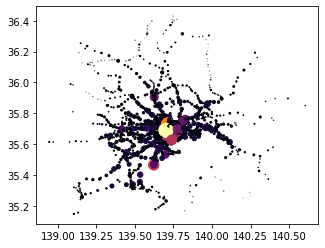

In [16]:
df_merged = gpd.GeoDataFrame(df_merged)
target_col = 'nlni_passenger_journeys_2017' #'passenger_journeys_2016_get_off_total' #'odpt_passenger_journeys_2017'

df_merged.plot(column=target_col, cmap='inferno', s=df_merged[target_col].dropna() / df_merged[target_col].max()*200)

json_str = df_merged.to_json('null')
with open('../work/passenger_survey.json', 'w') as f:
    f.write(json_str)

In [17]:
route_station_jp_list, station_code_list = df_merged[['route_station_jp', 'station_code']].to_dict(orient='list').values()
station_to_code = dict(zip(route_station_jp_list, station_code_list))

In [18]:
def read_nlni_railroad_section(src_dir='../data/railroad'):
    df = gpd.read_file(os.path.join(src_dir, 'N02-18_RailroadSection.geojson'))
    df = df[df['N02_004'] != '神戸電鉄']
    df['route_jp'] = df['N02_003'].apply(lambda x:re.sub(r'[0-9]号線', '', x))
    df['route_jp'] = df['route_jp'].apply(lambda x: reduce(lambda a,b: a.replace(*b), nlni_replace_list, x))
    df['route_jp'] = df['route_jp'].apply(lambda x: jaconv.h2z(x))
    return df

df_nlni_railroad_section = read_nlni_railroad_section()
df_nlni_railroad_section[df_nlni_railroad_section['N02_003']=='東海道線']

,N02_001,N02_002,N02_003,N02_004,geometry,route_jp
8903,11,2,東海道線,西日本旅客鉄道,"LINESTRING (136.28993 35.31500, 136.28908 35.3...",東海道本線
8904,11,2,東海道線,西日本旅客鉄道,"LINESTRING (136.28984 35.31389, 136.29061 35.3...",東海道本線
8905,11,2,東海道線,西日本旅客鉄道,"LINESTRING (135.97042 35.02945, 135.97100 35.0...",東海道本線
8906,11,2,東海道線,西日本旅客鉄道,"LINESTRING (136.14451 35.15194, 136.14505 35.1...",東海道本線
8907,11,2,東海道線,西日本旅客鉄道,"LINESTRING (136.02365 35.06935, 136.02113 35.0...",東海道本線
...,...,...,...,...,...,...
21793,11,2,東海道線,東海旅客鉄道,"LINESTRING (137.16035 34.88710, 137.16038 34.8...",東海道本線
21926,11,2,東海道線,西日本旅客鉄道,"LINESTRING (135.22583 34.70890, 135.22513 34.7...",東海道本線
21927,11,2,東海道線,西日本旅客鉄道,"LINESTRING (135.22335 34.70803, 135.22241 34.7...",東海道本線
21974,11,2,東海道線,西日本旅客鉄道,"LINESTRING (135.57704 34.82815, 135.57637 34.8...",東海道本線


In [19]:
route_code_list = set(df_merged['route_code'])

railroad_section_link = []
for route_code in route_code_list:
    df_by_route = df_merged[df_merged['route_code']==route_code].sort_values('station_code')
    if df_by_route['route_jp'].iloc[0] in ['東海道新幹線', '上越新幹線', '東北新幹線']:
        continue
    pairs = list(zip(
        df_by_route.iloc[:-1].to_dict(orient='record'),
        df_by_route.iloc[1:].to_dict(orient='record')))
    for s_start, s_end in pairs:
        record = {
            'route_jp': s_start['route_jp'],
            'route_station_jp_start': s_start['route_station_jp'],
            'route_station_jp_end': s_end['route_station_jp'],
            'station_code_start': s_start['station_code'],
            'station_code_end': s_end['station_code'],
            'edge_start': s_start['geometry'].coords[:][0],
            'edge_end': s_end['geometry'].coords[:][0],
        }
        record['geometry'] = LineString([record['edge_start'], record['edge_end']])
        railroad_section_link.append(record)
railroad_section_link = pd.DataFrame(railroad_section_link)
railroad_section_link

,route_jp,route_station_jp_start,route_station_jp_end,station_code_start,station_code_end,edge_start,edge_end,geometry
0,押上線,押上線_押上,押上線_京成曳舟,50101,50102,"(139.81158, 35.70972)","(139.81963, 35.71812)","LINESTRING (139.81158 35.70972, 139.81963 35.7..."
1,押上線,押上線_京成曳舟,押上線_八広,50102,50103,"(139.81963, 35.71812)","(139.82889, 35.72774)","LINESTRING (139.81963 35.71812, 139.82889 35.7..."
2,押上線,押上線_八広,押上線_四ツ木,50103,50104,"(139.82889, 35.72774)","(139.83398, 35.73126)","LINESTRING (139.82889 35.72774, 139.83398 35.7..."
3,押上線,押上線_四ツ木,押上線_京成立石,50104,50105,"(139.83398, 35.73126)","(139.84734, 35.73804)","LINESTRING (139.83398 35.73126, 139.84734 35.7..."
4,押上線,押上線_京成立石,押上線_青砥,50105,50106,"(139.84734, 35.73804)","(139.85585, 35.74532)","LINESTRING (139.84734 35.73804, 139.85585 35.7..."
...,...,...,...,...,...,...,...,...
1408,大江戸線,大江戸線_落合南長崎,大江戸線_新江古田,05333,05334,"(139.68387, 35.72282)","(139.67133, 35.73221)","LINESTRING (139.68387 35.72282, 139.67133 35.7..."
1409,大江戸線,大江戸線_新江古田,大江戸線_練馬,05334,05335,"(139.67133, 35.73221)","(139.65551, 35.73748)","LINESTRING (139.67133 35.73221, 139.65551 35.7..."
1410,大江戸線,大江戸線_練馬,大江戸線_豊島園,05335,05336,"(139.65551, 35.73748)","(139.64918, 35.74074)","LINESTRING (139.65551 35.73748, 139.64918 35.7..."
1411,大江戸線,大江戸線_豊島園,大江戸線_練馬春日町,05336,05337,"(139.64918, 35.74074)","(139.64161, 35.75108)","LINESTRING (139.64918 35.74074, 139.64161 35.7..."


In [20]:
# extract_edge_start = lambda x: x.coords[:][0]
# extract_edge_end = lambda x: x.coords[:][-1]

# route_jp_list = set(df_nlni_railroad_section['route_jp'])

# railroad_section_links = []
# # for target_route_jp in route_jp_list:
# if True:

#     railroad_section = df_nlni_railroad_section#[df_nlni_railroad_section['route_jp']==target_route_jp]
#     station = df_nlni_station#[df_nlni_station['route_jp']==target_route_jp]

#     # 端点を取得
#     railroad_section['edge_start'] = railroad_section['geometry'].apply(extract_edge_start)
#     railroad_section['edge_end'] = railroad_section['geometry'].apply(extract_edge_end)
#     railroad_section['join_key'] = railroad_section.apply(lambda x: x['route_jp']+str(extract_edge_start(x['geometry'])), axis=1)
#     station['edge_start'] = station['geometry'].apply(extract_edge_start)
#     station['edge_end'] = station['geometry'].apply(extract_edge_end)
#     station['join_key'] = station.apply(lambda x: x['route_jp']+str(extract_edge_start(x['geometry'])), axis=1)

#     # 駅を特定
#     railroad_section = pd.merge(railroad_section, station[['edge_start', 'route_station_jp', 'join_key']], on='join_key', how='left', suffixes=('', '_station'))
#     # linkのみを抽出
#     railroad_section_link_sub = railroad_section[railroad_section['route_station_jp'].isnull()]

#     railroad_section_link_sub = pd.merge(railroad_section_link_sub, station[['edge_end', 'route_station_jp']], left_on='edge_start', right_on='edge_end', suffixes=('', '_start'))
#     railroad_section_link_sub = pd.merge(railroad_section_link_sub, station[['edge_start', 'route_station_jp']], left_on='edge_end', right_on='edge_start', suffixes=('', '_end'))
#     railroad_section_links.append(railroad_section_link_sub)

# railroad_section_link = pd.concat(railroad_section_links)

# station_to_code_func = lambda x: station_to_code[x] if x in station_to_code else None
# railroad_section_link['station_code_start'] = railroad_section_link['route_station_jp_start'].apply(station_to_code_func)
# railroad_section_link['station_code_end'] = railroad_section_link['route_station_jp_end'].apply(station_to_code_func)
# # railroad_section_link = railroad_section_link[(railroad_section_link['station_code_start'].notnull() | railroad_section_link['station_code_end'].notnull())]

# remove_columns = [
#     'N02_001',
#     'N02_002',
#     'N02_003',
#     'N02_004',
#     'route_station_jp',
#     'edge_end_start',
#     'edge_start_end',
#     'join_key',
#     'edge_start_station',
# ]

# railroad_section_link = railroad_section_link.drop(remove_columns, axis=1)

# railroad_section_link = gpd.GeoDataFrame(railroad_section_link)



# railroad_section_link[railroad_section_link['route_jp'] =='目黒線']

In [21]:
df_dup_station = df_merged[['station_jp', 'route_jp']].groupby('station_jp').count()
df_dup_station = df_dup_station[df_dup_station['route_jp']>2]
transfer_station_list = list(df_dup_station.index)

transfer_pair_list = []
for station in transfer_station_list:
    station_codes = df_merged[df_merged['station_jp']==station]['station_code'].to_list()
    pairs = list(itertools.combinations(station_codes, 2))
    transfer_pair_list += pairs

# for start, end in zip(tx_stations[:-1], tx_stations[1:]):
#     transfer_pair_list.append([station_to_code[start[0]], station_to_code[end[0]]])

df_transfer = []
for pair in transfer_pair_list:
    if '45533' in pair or '01813' in pair:
        # skip 東上線_小川町 八高線_小川町
        continue
    station_start_i, station_end_i = pair
    station_start, station_end = [df_merged[df_merged['station_code']==x].iloc[0] for x in pair]
    edge_start, edge_end = [df_merged[df_merged['station_code']==x].iloc[0]['geometry'].coords[:][0] for x in pair]
    record = {
        'geometry': LineString((edge_start, edge_end)),
        'route_jp': station_start['route_jp'],
        'edge_start': edge_start,
        'edge_end': edge_end,
        'route_station_jp_start': station_start['route_station_jp'],
        'route_station_jp_end': station_end['route_station_jp'],
        'station_code_start': station_start_i,
        'station_code_end': station_end_i,
    }
    df_transfer.append(record)
df_transfer = pd.DataFrame(df_transfer)
railroad_section_link = pd.concat([railroad_section_link, df_transfer])
railroad_section_link = railroad_section_link.dropna(subset=['station_code_start', 'station_code_end'])
railroad_section_link['start_end'] = railroad_section_link.apply(lambda x: '{}_{}'.format(x['station_code_start'], x['station_code_end']), axis=1)

railroad_section_link =  gpd.GeoDataFrame(railroad_section_link)
railroad_section_link


,route_jp,route_station_jp_start,route_station_jp_end,station_code_start,station_code_end,edge_start,edge_end,geometry,start_end
0,押上線,押上線_押上,押上線_京成曳舟,50101,50102,"(139.81158, 35.70972)","(139.81963, 35.71812)","LINESTRING (139.81158 35.70972, 139.81963 35.7...",50101_50102
1,押上線,押上線_京成曳舟,押上線_八広,50102,50103,"(139.81963, 35.71812)","(139.82889, 35.72774)","LINESTRING (139.81963 35.71812, 139.82889 35.7...",50102_50103
2,押上線,押上線_八広,押上線_四ツ木,50103,50104,"(139.82889, 35.72774)","(139.83398, 35.73126)","LINESTRING (139.82889 35.72774, 139.83398 35.7...",50103_50104
3,押上線,押上線_四ツ木,押上線_京成立石,50104,50105,"(139.83398, 35.73126)","(139.84734, 35.73804)","LINESTRING (139.83398 35.73126, 139.84734 35.7...",50104_50105
4,押上線,押上線_京成立石,押上線_青砥,50105,50106,"(139.84734, 35.73804)","(139.85585, 35.74532)","LINESTRING (139.84734 35.73804, 139.85585 35.7...",50105_50106
...,...,...,...,...,...,...,...,...,...
321,京王線,京王線_高幡不動,多摩都市モノレール線_高幡不動,30029,87007,"(139.41397, 35.66188)","(139.41516, 35.66095)","LINESTRING (139.41397 35.66188, 139.41516 35.6...",30029_87007
322,京王線,京王線_高幡不動,多摩都市モノレール線_高幡不動,30201,87007,"(139.41397, 35.66188)","(139.41516, 35.66095)","LINESTRING (139.41397 35.66188, 139.41516 35.6...",30201_87007
323,東西線,東西線_高田馬場,新宿線_高田馬場,15403,40002,"(139.70603, 35.7128)","(139.7037, 35.71176)","LINESTRING (139.70603 35.71280, 139.70370 35.7...",15403_40002
324,東西線,東西線_高田馬場,山手線_高田馬場,15403,01011,"(139.70603, 35.7128)","(139.70423, 35.7141)","LINESTRING (139.70603 35.71280, 139.70423 35.7...",15403_01011


In [22]:
# railroad_section_link['length'] = railroad_section_link.apply(lambda x: (x['edge_start'][0] - x['edge_end'][0])**2, axis=1)
# railroad_section_link.sort_values('length')


In [23]:
def read_transport_capacity(src_dir='../data/railroad', station_to_code=None):
    wb = xlrd.open_workbook(os.path.join(src_dir, '001178999.xlsx'))

    sheet = wb.sheets()[0]

    operator_jp, route_jp, direction = [None] * 3
    route_count = 0
    records = []

    col_num = len(sheet.row_values(0))
    row_num = len(sheet.col_values(0))

    for x in range(2, row_num):
        record = sheet.row_values(x)
        if record[0] != '':
            operator_jp = record[0]
        if record[1] != '':
            route_jp = record[1]
        if record[2] != '':
            direction = record[2]
        if record[3] == '':
            continue
        records.append([operator_jp, route_jp, direction] + record[3:])
    columns = [
        'operator_jp',
        'route_jp',
        'direction_jp',
        'station_jp_start',
        'station_jp_end',
        'capacity_0200_0659',
        'capacity_0700_0729',
        'capacity_0730_0759',
        'capacity_0800_0829',
        'capacity_0830_0859',
        'capacity_0900_0929',
        'capacity_0930_0959',
        'capacity_1000_1059',
        'capacity_1100_1259',
        'capacity_1300_1459',
        'capacity_1500_1659',
        'capacity_1700_1759',
        'capacity_1800_1859',
        'capacity_1900_1959',
        'capacity_2000_2059',
        'capacity_2100_2159',
        'capacity_2200_2259',
        'capacity_2300_2359',
        'capacity_2400_0159',
    ]
    df = pd.DataFrame(records, columns=columns)
    # 京葉線（１） -> 京葉線,  上野東京ライン（1） -> 上野東京ライン
    df['route_jp'] = df['route_jp'].apply(lambda x: re.sub(r'[(（][0-9０-９][)）]', '', x))
    replace_list = [
        ('高尾線', '京王線'),
        ('動物園線', '京王線'),
        ('相模原線', '京王線'),
        ('伊勢崎線', '東武スカイツリーライン'),
        ('各駅停車', ''),
        ('快速', ''),
        (' ', ''),
    ]
    df['route_jp'] = df['route_jp'].apply(lambda x: reduce(lambda a,b: a.replace(*b), replace_list, x))
    df['route_jp'] = df['route_jp'].apply(lambda x: jaconv.h2z(x))
    df['station_jp_start'] = df['station_jp_start'].apply(lambda x: jaconv.h2z(x, digit=True))
    df['station_jp_end'] = df['station_jp_end'].apply(lambda x: jaconv.h2z(x, digit=True))

    df['route_station_jp_start'] = df.apply(lambda x: '{}_{}'.format(x['route_jp'], x['station_jp_start']), axis=1)
    df['route_station_jp_end'] = df.apply(lambda x: '{}_{}'.format(x['route_jp'], x['station_jp_end']), axis=1)
    df['station_code_start'] = df['route_station_jp_start'].apply(lambda x: station_to_code[x] if x in station_to_code else None)
    df['station_code_end'] = df['route_station_jp_end'].apply(lambda x: station_to_code[x] if x in station_to_code else None)
    df = df.dropna(subset=['route_station_jp_start', 'route_station_jp_end'])
    # TODO resample capacity values by hour
    return df
df_transport_capacity = read_transport_capacity(station_to_code=station_to_code)
df_transport_capacity

,operator_jp,route_jp,direction_jp,station_jp_start,station_jp_end,capacity_0200_0659,capacity_0700_0729,capacity_0730_0759,capacity_0800_0829,capacity_0830_0859,...,capacity_1900_1959,capacity_2000_2059,capacity_2100_2159,capacity_2200_2259,capacity_2300_2359,capacity_2400_0159,route_station_jp_start,route_station_jp_end,station_code_start,station_code_end
0,東日本旅客鉄道,東海道本線,下り,東京,新橋,12692.0,5996.0,8096.0,10120.0,10120.0,...,16094.0,16188.0,15688.0,12748.0,14772.0,0.0,東海道本線_東京,東海道本線_新橋,00101,00102
1,東日本旅客鉄道,東海道本線,下り,新橋,品川,12692.0,3972.0,10120.0,10120.0,8096.0,...,16094.0,16188.0,15688.0,12748.0,14772.0,0.0,東海道本線_新橋,東海道本線_品川,00102,00103
2,東日本旅客鉄道,東海道本線,下り,品川,川崎,15416.0,5296.0,6072.0,8096.0,8096.0,...,16094.0,16188.0,15688.0,12748.0,14772.0,2024.0,東海道本線_品川,東海道本線_川崎,00103,00104
3,東日本旅客鉄道,東海道本線,下り,川崎,横浜,13392.0,5996.0,5372.0,8096.0,8096.0,...,15084.0,14164.0,15688.0,14772.0,14772.0,4048.0,東海道本線_川崎,東海道本線_横浜,00104,00105
4,東日本旅客鉄道,東海道本線,下り,横浜,戸塚,11368.0,8720.0,4672.0,10120.0,12144.0,...,19132.0,18212.0,19736.0,16796.0,16796.0,8096.0,東海道本線_横浜,東海道本線_戸塚,00105,00106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,首都圏新都市鉄道,つくばエクスプレス,上り,青井,北千住,14796.0,6576.0,8220.0,9042.0,8220.0,...,9864.0,9864.0,8220.0,6576.0,5754.0,0.0,つくばエクスプレス_青井,つくばエクスプレス_北千住,94006,94005
2412,首都圏新都市鉄道,つくばエクスプレス,上り,北千住,南千住,14796.0,5754.0,8220.0,9042.0,7398.0,...,10686.0,9042.0,8220.0,6576.0,5754.0,822.0,つくばエクスプレス_北千住,つくばエクスプレス_南千住,94005,94004
2413,首都圏新都市鉄道,つくばエクスプレス,上り,南千住,浅草,13974.0,5754.0,8220.0,9042.0,7398.0,...,9864.0,9864.0,8220.0,6576.0,5754.0,822.0,つくばエクスプレス_南千住,つくばエクスプレス_浅草,94004,94003
2414,首都圏新都市鉄道,つくばエクスプレス,上り,浅草,新御徒町,13152.0,5754.0,8220.0,9042.0,8220.0,...,9042.0,9864.0,8220.0,7398.0,5754.0,822.0,つくばエクスプレス_浅草,つくばエクスプレス_新御徒町,94003,94002


In [24]:
transport_capacity_traced = []
for _, row in df_transport_capacity.iterrows():
    station_code_start = row['station_code_start']
    station_code_end = row['station_code_end']
    if station_code_start is None or station_code_end is None:
        continue
    route_code = row['station_code_start'][0:3]
    route_jp = row['route_jp']
    # print(route_code, route_jp) # TODO debug
    df_route_link = railroad_section_link[
        railroad_section_link['station_code_start'].apply(lambda x: x[0:3] == route_code ) & \
        railroad_section_link['station_code_end'].apply(lambda x: x[0:3] == route_code )
        ]
    if station_code_end > station_code_start:
        direction = 1
        col_start = 'station_code_start'
        col_end = 'station_code_end'
    else:
        direction = -1
        col_start = 'station_code_end'
        col_end = 'station_code_start'
    df_target_section = df_route_link[
        df_route_link[col_start].apply(lambda x: int(x) >= int(station_code_start)) & \
        df_route_link[col_end].apply(lambda x: int(x) <= int(station_code_end))
        ]
    for _, traced_row in df_target_section.iterrows():
        rec = {
            **traced_row,
            **row,
            'direction': direction,
            'station_code_start': station_code_start if direction > 0 else station_code_end,
            'station_code_end': station_code_end if direction > 0 else station_code_start,
        }
        rec['start_end'] = '{}_{}'.format(rec['station_code_start'], rec['station_code_end'])
        transport_capacity_traced.append(rec)
    # break
df_transport_capacity_traced = pd.DataFrame(transport_capacity_traced)
df_transport_capacity_traced = pd.merge(
    df_transport_capacity_traced[df_transport_capacity_traced['direction'] > 0],
    df_transport_capacity_traced[df_transport_capacity_traced['direction'] < 0],
    on='start_end', suffixes=['_down', '_up']
    )

transport_capacity_columns = [
    'capacity_0200_0659_down', 'capacity_0700_0729_down',
    'capacity_0730_0759_down', 'capacity_0800_0829_down',
    'capacity_0830_0859_down', 'capacity_0900_0929_down',
    'capacity_0930_0959_down', 'capacity_1000_1059_down',
    'capacity_1100_1259_down', 'capacity_1300_1459_down',
    'capacity_1500_1659_down', 'capacity_1700_1759_down',
    'capacity_1800_1859_down', 'capacity_1900_1959_down',
    'capacity_2000_2059_down', 'capacity_2100_2159_down',
    'capacity_2200_2259_down', 'capacity_2300_2359_down',
    'capacity_2400_0159_down', 
    'capacity_0200_0659_up',
    'capacity_0700_0729_up', 'capacity_0730_0759_up',
    'capacity_0800_0829_up', 'capacity_0830_0859_up',
    'capacity_0900_0929_up', 'capacity_0930_0959_up',
    'capacity_1000_1059_up', 'capacity_1100_1259_up',
    'capacity_1300_1459_up', 'capacity_1500_1659_up',
    'capacity_1700_1759_up', 'capacity_1800_1859_up',
    'capacity_1900_1959_up', 'capacity_2000_2059_up',
    'capacity_2100_2159_up', 'capacity_2200_2259_up',
    'capacity_2300_2359_up', 'capacity_2400_0159_up',
    'start_end',
]

df_transport_capacity_traced = gpd.GeoDataFrame(df_transport_capacity_traced)
df_transport_capacity_traced
df_railroad_section_link = pd.merge(railroad_section_link, df_transport_capacity_traced[transport_capacity_columns], on='start_end', how='left')
df_railroad_section_link = gpd.GeoDataFrame(df_railroad_section_link)
df_railroad_section_link

,route_jp,route_station_jp_start,route_station_jp_end,station_code_start,station_code_end,edge_start,edge_end,geometry,start_end,capacity_0200_0659_down,...,capacity_1300_1459_up,capacity_1500_1659_up,capacity_1700_1759_up,capacity_1800_1859_up,capacity_1900_1959_up,capacity_2000_2059_up,capacity_2100_2159_up,capacity_2200_2259_up,capacity_2300_2359_up,capacity_2400_0159_up
0,押上線,押上線_押上,押上線_京成曳舟,50101,50102,"(139.81158, 35.70972)","(139.81963, 35.71812)","LINESTRING (139.81158 35.70972, 139.81963 35.7...",50101_50102,15488.0,...,11616.0,14520.0,11616.0,13552.0,10648.0,9680.0,7744.0,9680.0,8712.0,968.0
1,押上線,押上線_京成曳舟,押上線_八広,50102,50103,"(139.81963, 35.71812)","(139.82889, 35.72774)","LINESTRING (139.81963 35.71812, 139.82889 35.7...",50102_50103,12584.0,...,11616.0,14520.0,11616.0,13552.0,10648.0,9680.0,7744.0,9680.0,8712.0,968.0
2,押上線,押上線_八広,押上線_四ツ木,50103,50104,"(139.82889, 35.72774)","(139.83398, 35.73126)","LINESTRING (139.82889 35.72774, 139.83398 35.7...",50103_50104,12584.0,...,11616.0,14520.0,11616.0,13552.0,10648.0,9680.0,7744.0,9680.0,8712.0,968.0
3,押上線,押上線_四ツ木,押上線_京成立石,50104,50105,"(139.83398, 35.73126)","(139.84734, 35.73804)","LINESTRING (139.83398 35.73126, 139.84734 35.7...",50104_50105,12584.0,...,11616.0,14520.0,11616.0,13552.0,10648.0,9680.0,7744.0,9680.0,8712.0,968.0
4,押上線,押上線_京成立石,押上線_青砥,50105,50106,"(139.84734, 35.73804)","(139.85585, 35.74532)","LINESTRING (139.84734 35.73804, 139.85585 35.7...",50105_50106,12584.0,...,23232.0,24200.0,15488.0,15488.0,15488.0,11616.0,8712.0,9680.0,8712.0,968.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,京王線,京王線_高幡不動,多摩都市モノレール線_高幡不動,30029,87007,"(139.41397, 35.66188)","(139.41516, 35.66095)","LINESTRING (139.41397 35.66188, 139.41516 35.6...",30029_87007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1747,京王線,京王線_高幡不動,多摩都市モノレール線_高幡不動,30201,87007,"(139.41397, 35.66188)","(139.41516, 35.66095)","LINESTRING (139.41397 35.66188, 139.41516 35.6...",30201_87007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1748,東西線,東西線_高田馬場,新宿線_高田馬場,15403,40002,"(139.70603, 35.7128)","(139.7037, 35.71176)","LINESTRING (139.70603 35.71280, 139.70370 35.7...",15403_40002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749,東西線,東西線_高田馬場,山手線_高田馬場,15403,01011,"(139.70603, 35.7128)","(139.70423, 35.7141)","LINESTRING (139.70603 35.71280, 139.70423 35.7...",15403_01011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


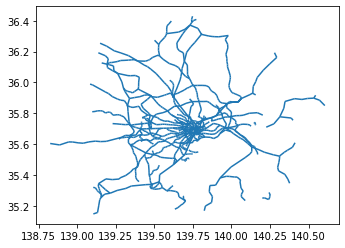

In [25]:
df_railroad_section_link.plot()
json_str = df_railroad_section_link.to_json('null')
with open('../work/railroad_path.json', 'w') as f:
    f.write(json_str)

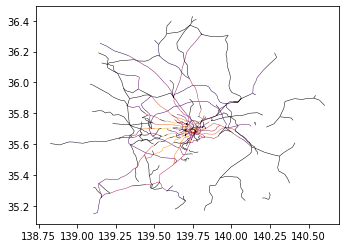

In [26]:
target_col = 'capacity_1700_1759_up'
df_railroad_section_link.fillna(0).plot(column=target_col, cmap='inferno', linewidth=0.5)

In [27]:
df_railroad_section_link[df_railroad_section_link['route_jp']=='つくばエクスプレス']

,route_jp,route_station_jp_start,route_station_jp_end,station_code_start,station_code_end,edge_start,edge_end,geometry,start_end,capacity_0200_0659_down,...,capacity_1300_1459_up,capacity_1500_1659_up,capacity_1700_1759_up,capacity_1800_1859_up,capacity_1900_1959_up,capacity_2000_2059_up,capacity_2100_2159_up,capacity_2200_2259_up,capacity_2300_2359_up,capacity_2400_0159_up
852,つくばエクスプレス,つくばエクスプレス_秋葉原,つくばエクスプレス_新御徒町,94001,94002,"(139.774219, 35.698683)","(139.78194, 35.707055)","LINESTRING (139.77422 35.69868, 139.78194 35.7...",94001_94002,13152.0,...,16440.0,16440.0,9864.0,9864.0,9864.0,9864.0,8220.0,6576.0,6576.0,822.0
853,つくばエクスプレス,つくばエクスプレス_新御徒町,つくばエクスプレス_浅草,94002,94003,"(139.78194, 35.707055)","(139.79843, 35.712074)","LINESTRING (139.78194 35.70705, 139.79843 35.7...",94002_94003,12330.0,...,16440.0,16440.0,9864.0,10686.0,9042.0,9864.0,8220.0,7398.0,5754.0,822.0
854,つくばエクスプレス,つくばエクスプレス_浅草,つくばエクスプレス_南千住,94003,94004,"(139.79843, 35.712074)","(139.799171, 35.733336)","LINESTRING (139.79843 35.71207, 139.79917 35.7...",94003_94004,12330.0,...,16440.0,16440.0,9864.0,9864.0,9864.0,9864.0,8220.0,6576.0,5754.0,822.0
855,つくばエクスプレス,つくばエクスプレス_南千住,つくばエクスプレス_北千住,94004,94005,"(139.799171, 35.733336)","(139.805108, 35.749412)","LINESTRING (139.79917 35.73334, 139.80511 35.7...",94004_94005,11508.0,...,16440.0,17262.0,9042.0,9864.0,10686.0,9042.0,8220.0,6576.0,5754.0,822.0
856,つくばエクスプレス,つくばエクスプレス_北千住,つくばエクスプレス_青井,94005,94006,"(139.805108, 35.749412)","(139.820436, 35.772034)","LINESTRING (139.80511 35.74941, 139.82044 35.7...",94005_94006,11508.0,...,16440.0,17262.0,9042.0,9864.0,9864.0,9864.0,8220.0,6576.0,5754.0,0.0
857,つくばエクスプレス,つくばエクスプレス_青井,つくばエクスプレス_六町,94006,94007,"(139.820436, 35.772034)","(139.821874, 35.784841)","LINESTRING (139.82044 35.77203, 139.82187 35.7...",94006_94007,10686.0,...,16440.0,17262.0,9864.0,9042.0,9864.0,9864.0,8220.0,6576.0,5754.0,0.0
1458,つくばエクスプレス,つくばエクスプレス_北千住,常磐線_北千住,94005,00605,"(139.805108, 35.749412)","(139.80449, 35.74835)","LINESTRING (139.80511 35.74941, 139.80449 35.7...",94005_00605,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,つくばエクスプレス,つくばエクスプレス_北千住,常磐線_北千住,94005,00701,"(139.805108, 35.749412)","(139.80449, 35.74835)","LINESTRING (139.80511 35.74941, 139.80449 35.7...",94005_00701,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,つくばエクスプレス,つくばエクスプレス_南千住,常磐線_南千住,94004,00604,"(139.799171, 35.733336)","(139.79925, 35.73366)","LINESTRING (139.79917 35.73334, 139.79925 35.7...",94004_00604,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1689,つくばエクスプレス,つくばエクスプレス_秋葉原,総武線_秋葉原,94001,00821,"(139.774219, 35.698683)","(139.77449, 35.6982)","LINESTRING (139.77422 35.69868, 139.77449 35.6...",94001_00821,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
